In [75]:
!pip install matplotlib pandas seaborn numpy

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
import os
ext=""
if os.name == 'nt':
    ext=".exe"
import shutil
shutil.copyfile("../src/cl/kernel.cl","./kernel.cl")
shutil.copyfile("../src/cl/kernel_bidimensional.cl","./kernel_bidimensional.cl")
shutil.copyfile("../src/cl/kernel_wth_local_mem.cl","./kernel_wth_local_mem.cl")
CPU_EXEC = "../build/src/MyProjectCPU"+ext
CL_EXEC = "../build/src/cl/MyProjectCL"+ext
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"+ext

current_path = os.getcwd()
naive_path = os.path.join(current_path, "nbody_naive_cl.csv")
local_mem_path = os.path.join(current_path, "nbody_local_mem_cl.csv")
bidimensional_path = os.path.join(current_path, "nbody_bidimensional_cl.csv")
variation_path = os.path.join(current_path, "nbody_variation_cl.csv")

Se crean funciones auxiliares, best rectangle calcula el mejor rectangulo que puede contener a cierta cantidad de bloques.

In [2]:
import math

#search the best rectangle grid to fit the area given
def best_rectangle(x):
    best_area = float('inf')
    rect = (0, 0)
    for width in range(1, int(math.sqrt(x)) + 2):
        length = math.ceil(x / width)
        area = width * length
        if area >= x and area <= best_area:
            best_area = area
            rect = (width, length)
    return rect

Funcion para ejecuciones de una dimensión, se define con anterioridad para utilizarla en sus variantes.

In [3]:
# "<mode> <array size> <local size> <global size> <local size y> <global size y> <local memory size> <output file>"
def run_1d_test(mode,path):
    for i in range(5, 14):
        array_size = 2 ** i
        print(f"Running for array size: {array_size}")
        # for para el tamaño del local_size
        for j in range(5,9):
            local_size = 2**j
            #for para la cantidad de bloques
            grids = int((array_size+local_size-1)/local_size)
            global_size=grids*local_size
            for _ in range(10):
                # Construir el comando
                command_shared_mem = [
                    CL_EXEC,
                    str(mode),
                    str(array_size),
                    str(local_size),
                    str(global_size),
                    str(1),
                    str(1),
                    str(local_size),
                    path
                ]
                # Ejecutar el comando
                result = subprocess.run(command_shared_mem, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                # Verificar si hubo algún error en la ejecución
                if result.returncode != 0:
                    print("Error during execution:")
                    print(result)


En primer lugar se harán los test. Se empezó con la variación de implementación "naive". Se realizaron múltiples test para diferentes valores de: cantidad de cuerpos y cantidad de threads por grupo (local size), diez veces para cada combinación de valores.

In [4]:
run_1d_test(1,naive_path)

Running for array size: 32
Running for array size: 64
Running for array size: 128
Running for array size: 256
Running for array size: 512
Running for array size: 1024
Running for array size: 2048
Running for array size: 4096
Running for array size: 8192


Se siguió con la variación de implementación "local memory" (memoria compartida). Se realizaron las mismas pruebas anteriores, definiendo el tamaño de la memoria compartida igual al local_size.

In [5]:
run_1d_test(2,local_mem_path)


Running for array size: 32
Running for array size: 64
Running for array size: 128
Running for array size: 256
Running for array size: 512
Running for array size: 1024
Running for array size: 2048
Running for array size: 4096
Running for array size: 8192


Se ejecutaron los mismos test con la variación de implementación "bidimensional" (mapeo en una grilla 2D en el kernel). para cada tamaño de bloque se probaron distintas combinaciones para organizar los valores en rectangulos, luego se calculó la mejor grilla que contuviera los bloques necesarios.

In [6]:
def Test_2d(path):
    for i in range(5, 14):
        array_size = 2 ** i
        print(f"Running for array size: {array_size}")
        # for para el tamaño de cada bloque
        for j in range(5,9):
            for k in range(0,j+1):
                #for para la cantidad de bloques
                local_size_x=2**k
                local_size_y=2**(j-k)
                grid_size = int((array_size+(2**j)-1)/(2**j))
                global_size_x,global_size_y=best_rectangle(grid_size)
                #10 iteraciones
                for _ in range(10):
                    # Construir el comando
                    command_bidimensional = [
                        CL_EXEC,
                        str(3),
                        str(array_size),
                        str(local_size_x),
                        str(global_size_x*local_size_x),
                        str(local_size_y),
                        str(global_size_y*local_size_y),
                        str(local_size_x*local_size_y),
                        path
                    ]
                    # Ejecutar el comando
                    result = subprocess.run(command_bidimensional, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                    # Verificar si hubo algún error en la ejecución
                    if result.returncode != 0:
                        print("Error during execution: CUDA")
                        print(result)
Test_2d(bidimensional_path)

Running for array size: 32
Running for array size: 64
Running for array size: 128
Running for array size: 256
Running for array size: 512
Running for array size: 1024
Running for array size: 2048
Running for array size: 4096
Running for array size: 8192


Finalmente se ejecutó la prueba en la ejecución de una dimensión sin memoria compartida donde se varian los tamaños de los bloques, se definió una cantidad de particulas fijas y un tamaño de bloque de 256, las pruebas se realizaron aplicando un offset entre -5 y 5 al tamaño de bloque, ejecutando 10 veces cada variación.

In [7]:
# "<mode> <array size> <local size> <global size> <local size y> <global size y> <local memory size> <output file>"
def Test_size_variation(path,r):
    array_size = 2**13
    print(f"Running for array size: {array_size}")
    local_size = 256
    for i in range(-r,r+1):
        f_local_size=local_size+i
        #for para la cantidad de bloques
        grid_size = int((array_size+f_local_size-1)/f_local_size)
        global_size=grid_size*f_local_size
        #10 iteraciones
        for _ in range(10):
            # Construir el comando
            command_shared_mem = [
                CL_EXEC,
                str(1),
                str(array_size),
                str(f_local_size),
                str(global_size),
                str(1),
                str(1),
                str(f_local_size),
                path
            ]
            # Ejecutar el comando
            result = subprocess.run(command_shared_mem, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            # Verificar si hubo algún error en la ejecución
            if result.returncode != 0:
                print("Error during execution:")
                print(result)
Test_size_variation(variation_path,5)

Running for array size: 8192


# Carga de los datos

Se leen los archivos .csv para llevar los datos a dataframes. Se asignan sus columnas de acuerdo a lo que guarda el ejecutable la implementación. Filtramos además aquellas ejecuciones incorrectas no detectadas (con tiempos de ejecución ilógicos).

In [8]:
naive_cl = pd.read_csv("nbody_naive_cl.csv", header=None)
local_mem_cl = pd.read_csv("nbody_local_mem_cl.csv", header=None)
bidimensional_cl = pd.read_csv("nbody_bidimensional_cl.csv", header=None)
variation_cl = pd.read_csv("nbody_variation_cl.csv", header=None)
# los tiempos se tomaron en microsegundo
columns = ["size", "local size", "global size", "local size y", "global size y", "local mem size", "create data time", "copy to device", "execution time", "copy to host"]
naive_cl.columns = columns
local_mem_cl.columns = columns
variation_cl.columns = columns
bidimensional_cl.columns = columns

# Filtrar los DataFrames
naive_cl_filtered = naive_cl.query('`execution time` >= 100')
local_mem_cl_filtered = local_mem_cl.query('`execution time` >= 100')
variation_cl_filtered = variation_cl.query('`execution time` >= 100')
bidimensional_cl_filtered = bidimensional_cl.query('`execution time` >= 100')


En primer lugar se muestra un gráfico de linea que muestra la relación entre el tiempo de ejecución vs la cantidad de cuerpos. Este gráfico no toma en cuenta combinaciones de valores de otros atributos, solo tiempos promedios de ejecución por cada versión de la implementación entre todos los test realizados.

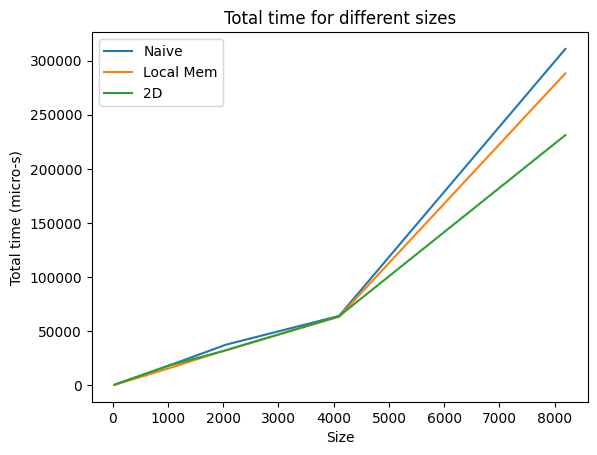

In [9]:
naive_cl_avg = naive_cl_filtered.groupby("size").mean()
local_mem_avg = local_mem_cl_filtered.groupby("size").mean()
bidimensional_cl_avg = bidimensional_cl_filtered.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(naive_cl_avg.index, naive_cl_avg["execution time"], label="Naive")
ax.plot(local_mem_avg.index, local_mem_avg["execution time"], label="Local Mem")
ax.plot(bidimensional_cl_avg.index, bidimensional_cl_avg["execution time"], label="2D")
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()

Este gráfico es similar al anterior, solo muestra tiempos promedios de ejecución por cada versión de la implementación entre todos los test realizados.

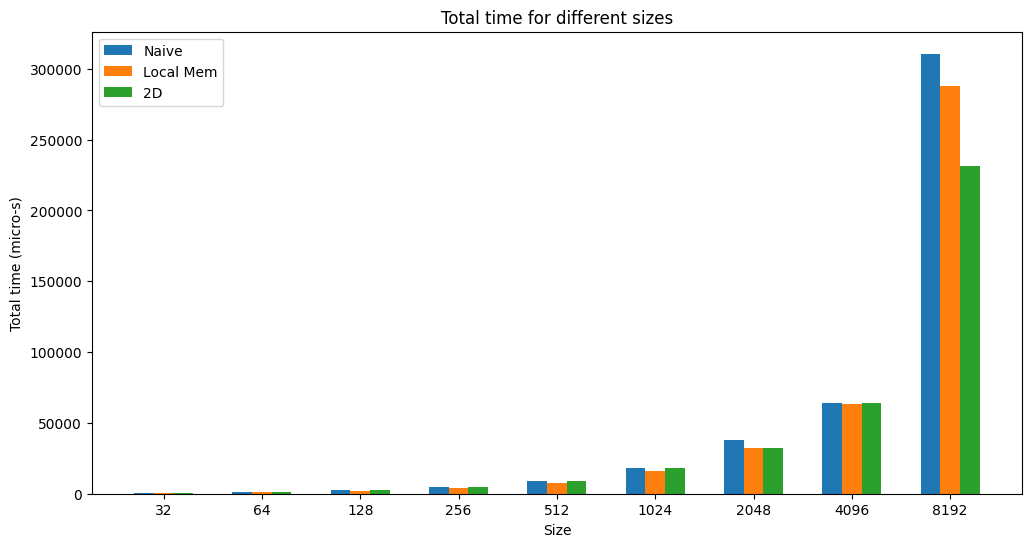

In [10]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2  # Ancho de las barras

# Posiciones de las barras en el eje x
x = np.arange(len(naive_cl_avg.index))

# Dibujar las barras
ax.bar(x - width, naive_cl_avg["execution time"], width, label="Naive")
ax.bar(x, local_mem_avg["execution time"], width, label="Local Mem")
ax.bar(x + width, bidimensional_cl_avg["execution time"], width, label="2D")

# Ajustar las etiquetas y el formato del eje x
ax.set_xlabel("Size")
ax.set_ylabel("Total time (micro-s)")
ax.set_xticks(x)
ax.set_xticklabels(naive_cl_avg.index)
ax.legend()
plt.title("Total time for different sizes")
plt.show()

# Análisis solo NAIVE

Esta versión de la implementación es la inicial, la que realiza los n**2 cálculos accediendo a memoria global, habiendo mapeado los threads en una grilla unidimensional.

In [11]:
naive_local_grouped_data = naive_cl_filtered.groupby(['size', 'local size'])['execution time'].mean().unstack()

#### Gráfico de Barra para "local size"

Se mostrará en un gráfico de barras la variación en el desempeño de la implementación para los distintos valores de "local size" (threads por grupo) testeados.

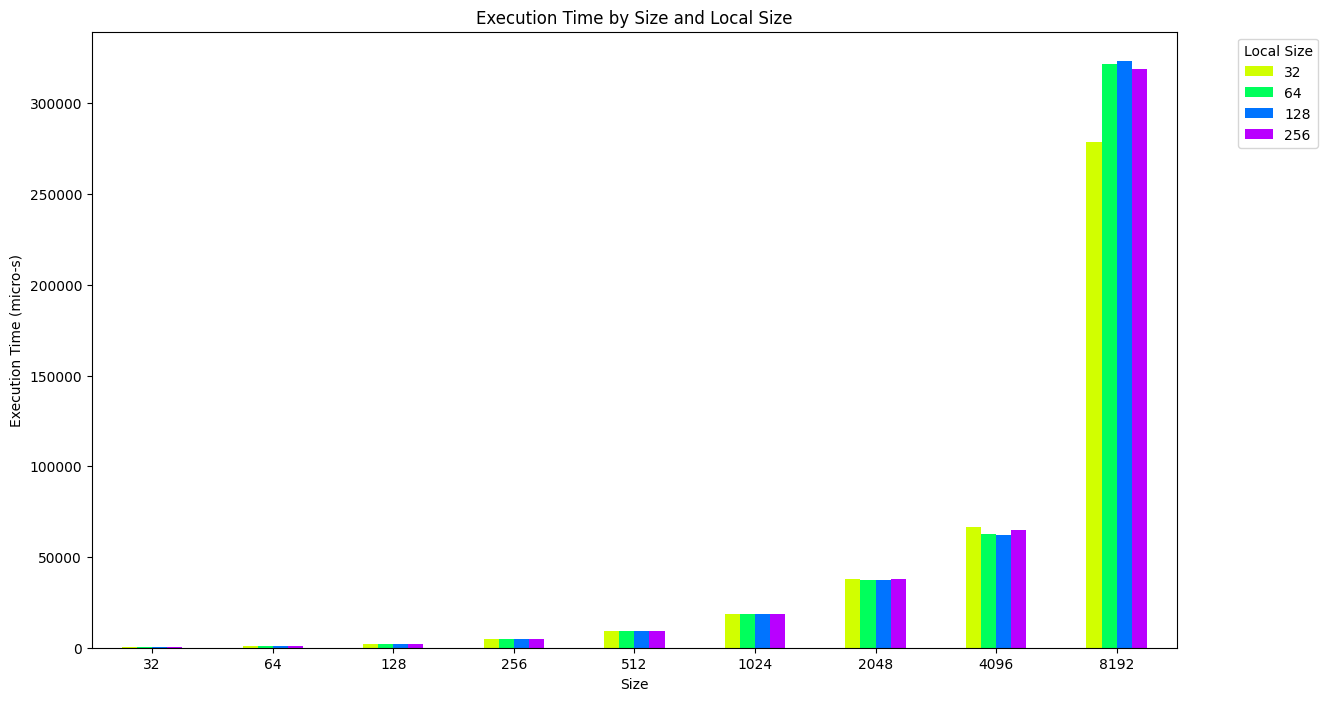

In [12]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))

# Configurar colores para cada local size
colors = sns.color_palette("hsv", len(naive_local_grouped_data.columns))

# Plotear cada local size como una barra separada
naive_local_grouped_data.plot(kind='bar', ax=ax, color=colors)

# Configuraciones adicionales del gráfico
ax.set_xlabel("Size")
ax.set_ylabel("Execution Time (micro-s)")
ax.set_title("Execution Time by Size and Local Size")
ax.legend(title="Local Size", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)
plt.show()

No se ve una tendencia para ningún valor de local size en particular, manteniendo valores cercanos para todas sus variaciones.


## Variaciones de Tamaño local

Se muestran los resultados de la ejecución de la variación de tamaños de bloques, promediando las pruebas realizadas de cada tamaño.

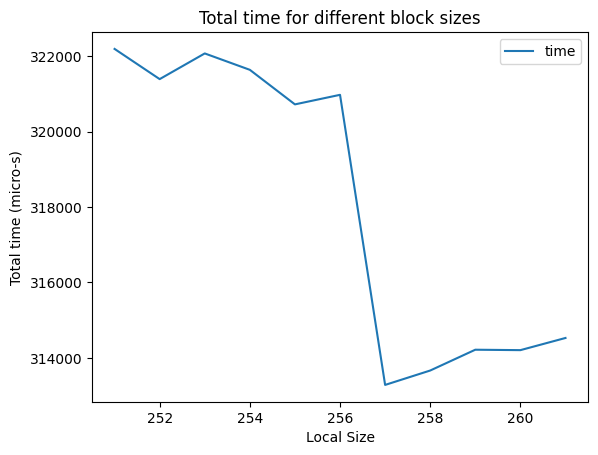

In [13]:
variation_cl_avg = variation_cl_filtered.groupby("local size").mean()

fig, ax = plt.subplots()
ax.plot(variation_cl_avg.index, variation_cl_avg["execution time"], label="time")
ax.set_xlabel("Local Size")
ax.set_ylabel("Total time (micro-s)")
ax.legend()
plt.title("Total time for different block sizes")
plt.show()

Podemos ver que para tamaños iguales y menores al bloque multiplo de 32 escogido (256) presentamos valores similares en la ejecución, mientras que para valores superiores los tiempos decendieron.

# Análisis solo Memoria Compartida

Esta versión de la implementación es segunda realizada, la que realiza los n**2 cálculos accediendo a memoria global para mover chunks de datos a memoria compartida habiendo mapeado los threads en una grilla unidimensional. Así solo se accede una fracción de veces al arreglo global (dependiendo del tamaño de la memoria compartida y del tamaño del arreglo global).

#### Gráfico de barras para "local size"

Se mostrará en un gráfico de barras la variación en el desempeño de la implementación para los distintos valores de "local size" (threads por grupo) testeados.

In [14]:
local_mem_local_grouped_data = local_mem_cl_filtered.groupby(['size', 'local size'])['execution time'].mean().unstack()

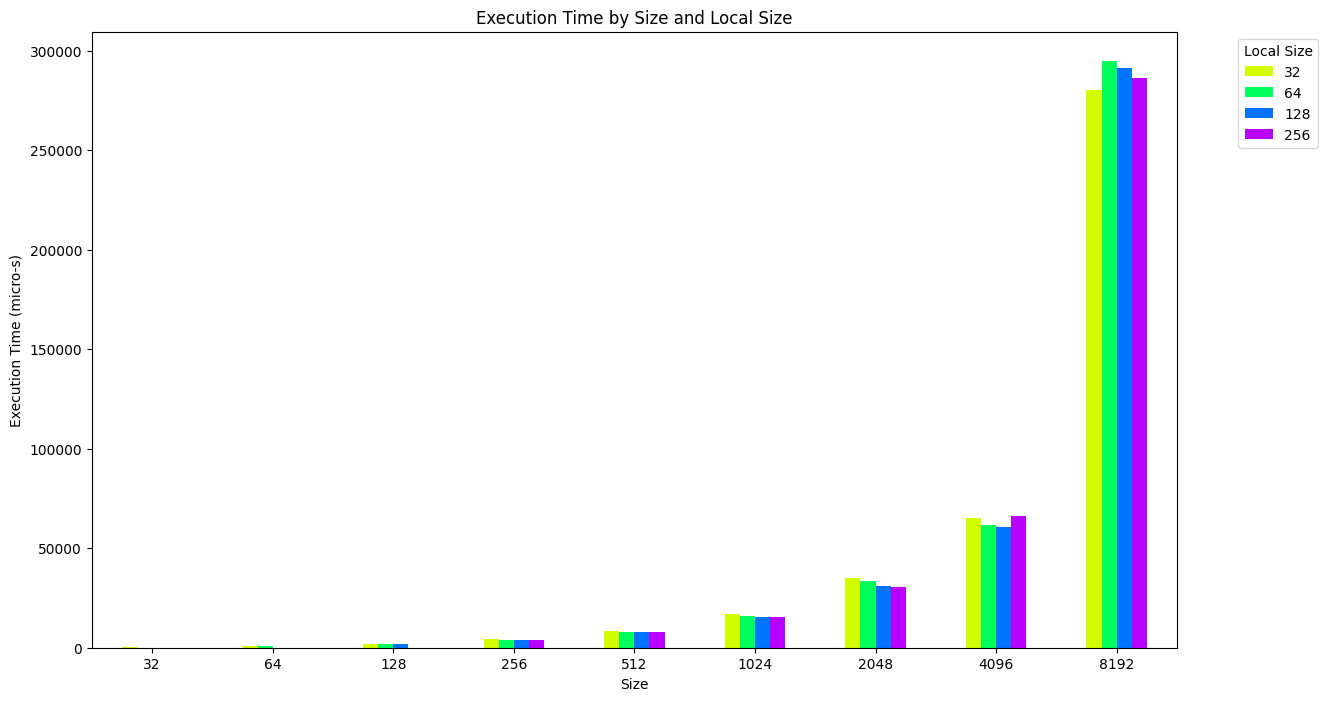

In [15]:
# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(14, 8))

# Configurar colores para cada local size
colors = sns.color_palette("hsv", len(local_mem_local_grouped_data.columns))

# Plotear cada local size como una barra separada
local_mem_local_grouped_data.plot(kind='bar', ax=ax, color=colors)

# Configuraciones adicionales del gráfico
ax.set_xlabel("Size")
ax.set_ylabel("Execution Time (micro-s)")
ax.set_title("Execution Time by Size and Local Size")
ax.legend(title="Local Size", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=0)
plt.show()

Se puede ver una leve variación en la cual hay un mejor desempeño para local size igual a 128.


# Análisis solo con grupos Bidimensionales

Esta versión de la implementación es la tercera realizada, la que realiza los n**2 cálculos accediendo a memoria global habiendo mapeado los threads en una grilla bidimensional. Esta grilla fue definida con diferentes valores de filas y columnas, esperando encontrar la mejor estructura de mapeo.

#### Pares (global size x, global size y) vs el size

Se mostrará en mapas de calor el tiempo de ejecución promedio de grillas dentro de un grupo (local size x, local size y) para valores específicos de size (cantidad de cuerpos).

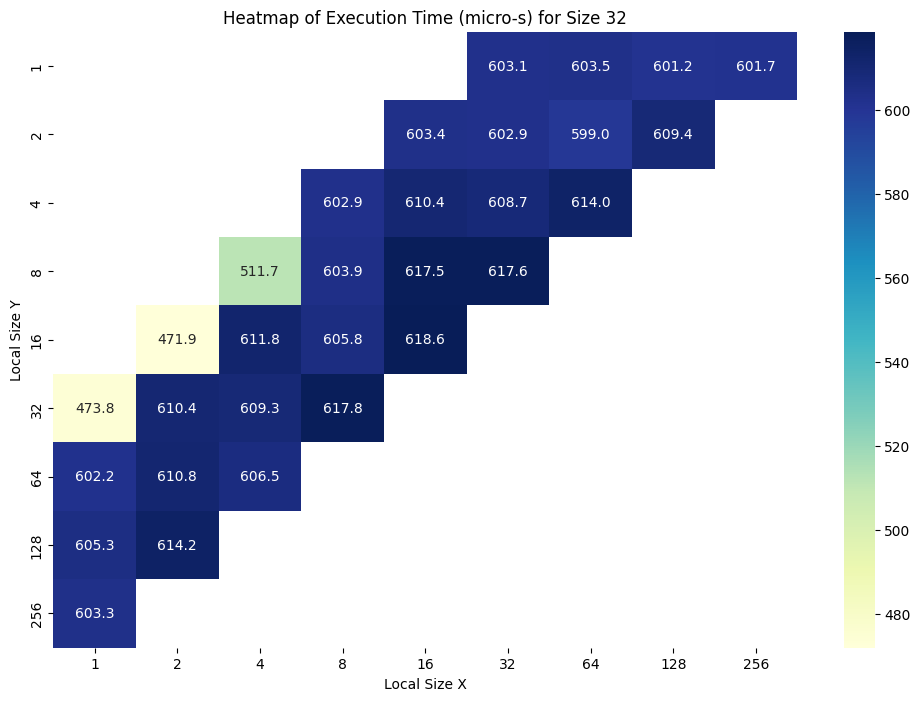

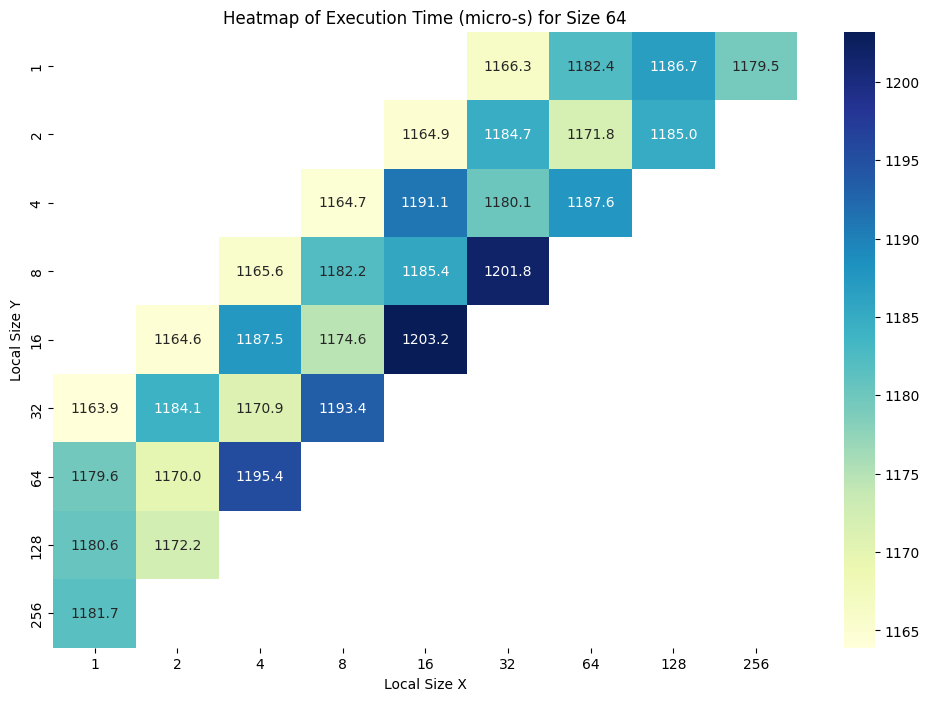

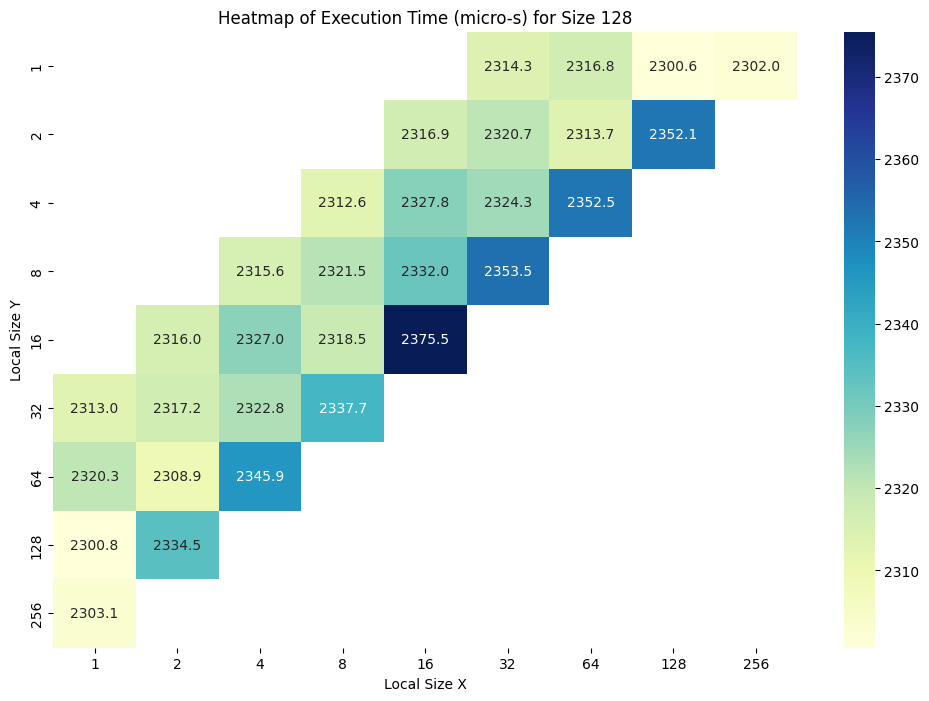

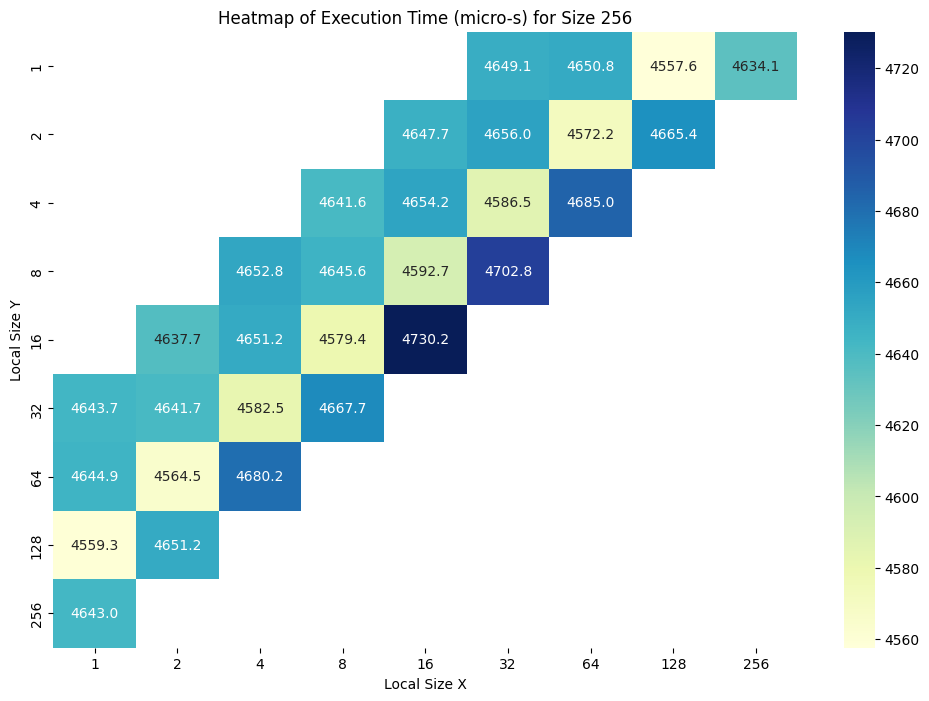

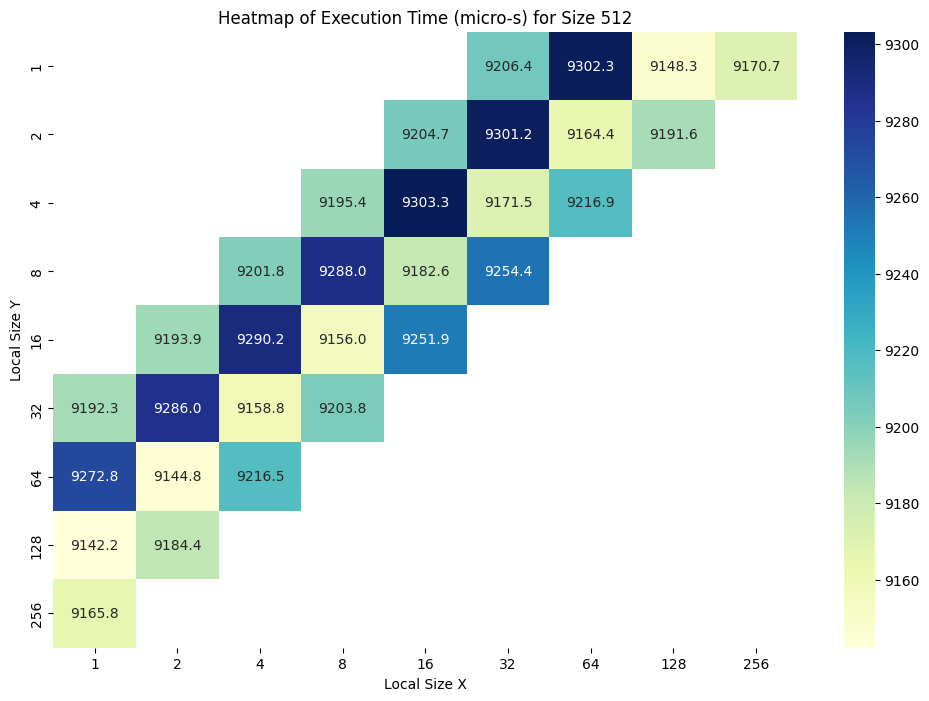

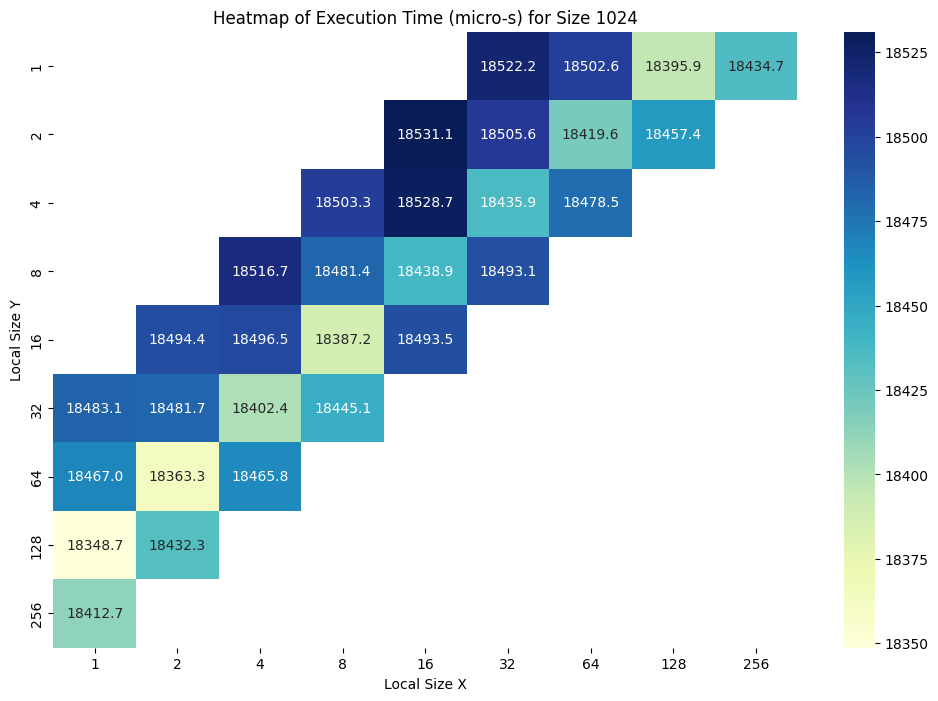

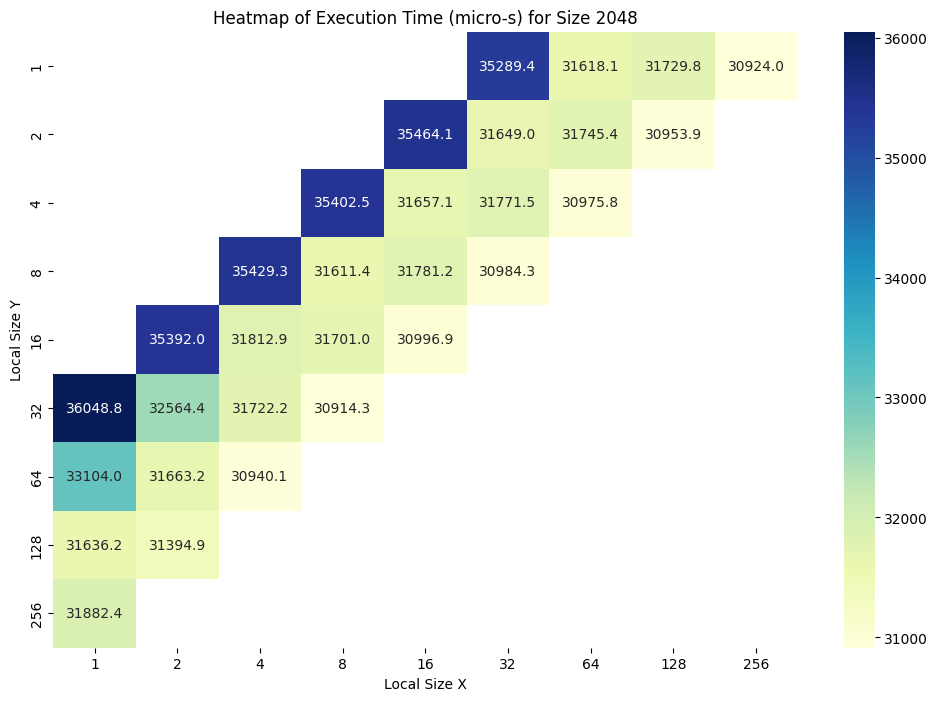

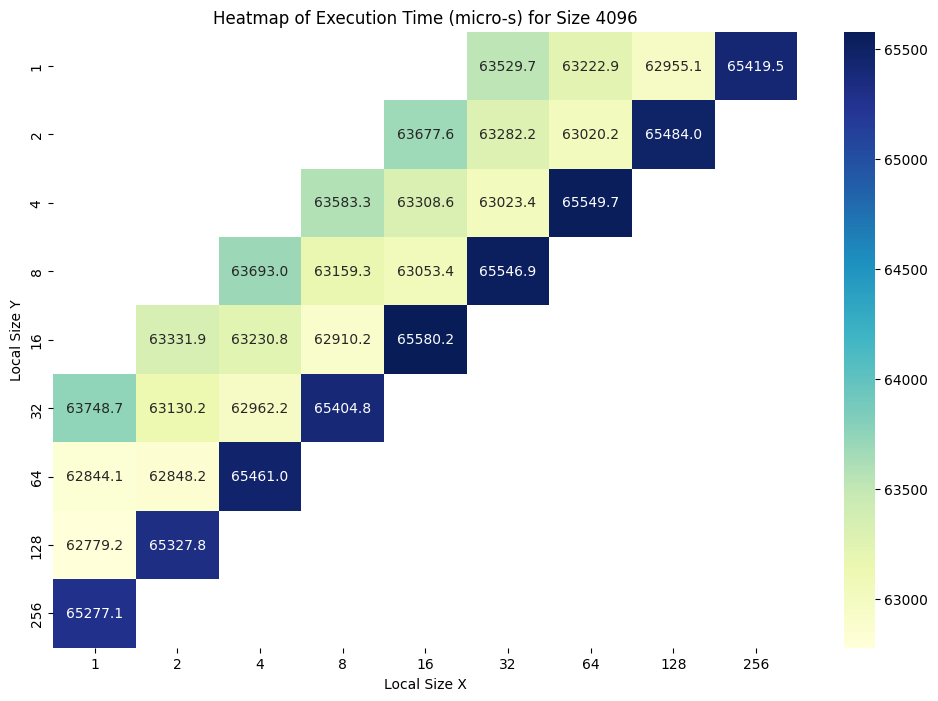

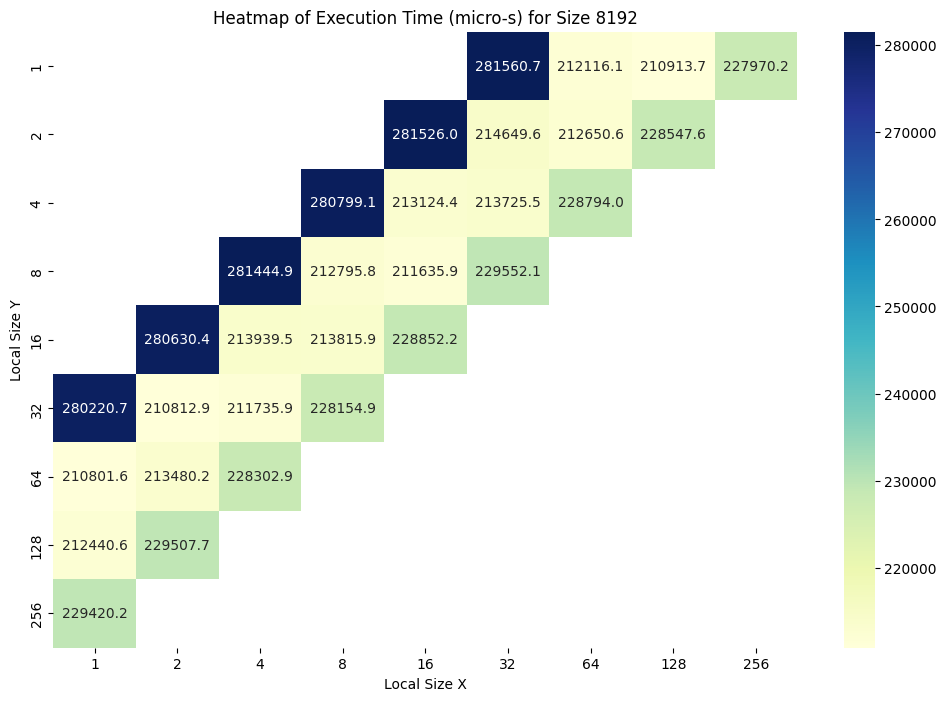

In [16]:
# Obtener los valores únicos de 'size'
unique_sizes = bidimensional_cl_filtered['size'].unique()

# Crear heatmaps para cada valor de 'size'
for size in unique_sizes:
    # Filtrar los datos por el tamaño actual
    size_data = bidimensional_cl_filtered[bidimensional_cl_filtered['size'] == size]
    
    # Crear una tabla pivot para facilitar el plotting
    pivot_table = size_data.pivot_table(values='execution time', index='local size y', columns='local size', aggfunc='mean')
    
    # Crear el heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title(f'Heatmap of Execution Time (micro-s) for Size {size}')
    plt.xlabel('Local Size X')
    plt.ylabel('Local Size Y')
    plt.show()

Para analizar estos resultados primero debemos notar que las diagonales corresponden a bloques del mismo tamaño, podemos observar que cuando la cantidad de particulas coincide con el tamaño total del bloque los tiempos suelen ser mejores en comparación al resto, limitado por el tamaño optimo de bloque de la gpu, en este caso 128 threads por bloque. de la misma manera al analizar las diagonales vemos que existe cierta mejora organizarse lo mas cercano a una dimensión, no podemos ver ninguna optimización referida a la distribución de los threads en el bloque, teniendo todos los de un mismo tamaño un tiempo similar.